In [1]:
!pip install --quiet pandas pandasql matplotlib

  Preparing metadata (setup.py) ... done


In [2]:
import pandas as pd
import numpy as np
from pandasql import sqldf
import matplotlib.pyplot as plt

# Helper for quick SQL on DataFrames
q = lambda sql: sqldf(sql, globals())

In [3]:
!pip install --quiet gdown

FILE_ID = "1_RK8iqkLXsLHiOsxmFtmoQjXCtRo7FVs"
!gdown --id $FILE_ID -O /content/orders.csv

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1_RK8iqkLXsLHiOsxmFtmoQjXCtRo7FVs
To: /content/orders.csv
100% 5.35M/5.35M [00:00<00:00, 67.3MB/s]


In [4]:
orders = pd.read_csv("/content/orders.csv",
                     parse_dates=["created_at", "paid_at"])

orders.head()

,invoice_id,line_item_id,user_id,item_id,item_name,item_category,price,created_at,paid_at
0,192320.0,83118.0,178481.0,3526.0,digital apparatus,apparatus,330.0,2017-06-28 21:14:25,2017-06-27 21:19:39
1,192320.0,207309.0,178481.0,1514.0,miniature apparatus cleaner,apparatus,99.0,2017-06-28 21:14:25,2017-06-27 21:19:39
2,192320.0,392027.0,178481.0,3712.0,miniature apparatus cleaner,apparatus,99.0,2017-06-28 21:14:25,2017-06-27 21:19:39
3,80902.0,243831.0,154133.0,3586.0,reflective instrument,instrument,57.2,2016-10-09 06:57:30,2016-10-07 10:08:10
4,80902.0,399806.0,154133.0,1061.0,extra-strength instrument charger,instrument,17.6,2016-10-09 06:57:30,2016-10-07 10:08:10


# **Question 1: Cohort Retention Analysis**

# **1. Standard cohort table**

In [7]:
# Month buckets as Periods
orders["order_month"]  = orders["created_at"].dt.to_period("M")
orders["cohort_month"] = (
    orders.groupby("user_id")["created_at"]
          .transform("min")
          .dt.to_period("M")
)

# Numeric months since cohort
orders["order_month_index"] = (
    orders["order_month"].astype(int)
  - orders["cohort_month"].astype(int)
)

orders[["user_id","order_month","cohort_month","order_month_index"]].head()

,user_id,order_month,cohort_month,order_month_index
0,178481.0,2017-06,2017-06,0
1,178481.0,2017-06,2017-06,0
2,178481.0,2017-06,2017-06,0
3,154133.0,2016-10,2016-10,0
4,154133.0,2016-10,2016-10,0


In [8]:
# Convert Periods - strings so pandasql can bind them
orders["order_month"]  = orders["order_month"].astype(str)
orders["cohort_month"] = orders["cohort_month"].astype(str)

In [9]:
# Standard cohort retention
cohort_counts = q("""
/* Cohort retention: raw active-user counts */
WITH first_purchase AS (
  SELECT user_id, MIN(cohort_month) AS cohort_month
  FROM orders
  GROUP BY user_id
)
SELECT
  f.cohort_month,
  o.order_month_index   AS month_n,
  COUNT(DISTINCT o.user_id) AS active_users
FROM orders o
JOIN first_purchase f
  ON o.user_id = f.user_id
GROUP BY f.cohort_month, month_n
ORDER BY f.cohort_month, month_n;
""")

# Pivot to matrix & compute %
pivot = (
    cohort_counts
      .pivot_table(
        index="cohort_month",
        columns="month_n",
        values="active_users",
        fill_value=0
      )
      .sort_index()
)
cohort_size   = pivot[0]
retention_pct = (pivot.div(cohort_size, axis=0)*100).round(2)

# Renameing: 0 - Cohort Size, 1 - Month 1, etc
col_renames = {0: "Cohort Size"}
col_renames.update({i: f"Month {i}" for i in range(1,13)})

retention_pct.rename(columns=col_renames, inplace=True)

for i in range(1, 13):
    col_name = f"Month {i}"
    if col_name not in retention_pct.columns:
        retention_pct[col_name] = 0.0

# Reorder columns
cols = ["Cohort Size"] + [f"Month {i}" for i in range(1, 13)]
retention_pct = retention_pct[cols]

display(retention_pct)

month_n,Cohort Size,Month 1,Month 2,Month 3,Month 4,Month 5,Month 6,Month 7,Month 8,Month 9,Month 10,Month 11,Month 12
cohort_month,,,,,,,,,,,,,
2013-03,100.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-04,100.0,0.00,0.00,0.00,12.50,12.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05,100.0,0.00,0.00,0.00,5.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-06,100.0,0.00,0.00,0.00,0.00,4.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-07,100.0,2.13,2.13,6.38,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02,100.0,1.85,1.85,1.62,0.23,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-03,100.0,1.74,1.53,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-04,100.0,1.75,0.22,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **2. Resurrection analysis**

In [10]:
# Resurrection analysis (inactive ≥2 months - comeback)

res_counts = q("""
/* Resurrection: users returning after ≥2 inactive months */
WITH user_months AS (
  SELECT DISTINCT user_id, order_month AS om
  FROM orders
),
ordered AS (
  SELECT
    user_id,
    om                    AS order_month,
    LAG(om) OVER (PARTITION BY user_id ORDER BY om) AS prev_month
  FROM user_months
),
gaps AS (
  SELECT
    user_id,
    order_month,
    prev_month,
    (
      (CAST(substr(order_month,1,4) AS INTEGER)*12 + CAST(substr(order_month,6,2) AS INTEGER))
    - (CAST(substr(prev_month,1,4)   AS INTEGER)*12 + CAST(substr(prev_month,6,2)   AS INTEGER))
    ) AS gap_months
  FROM ordered
)
SELECT
  f.cohort_month       AS cohort_month,
  g.gap_months         AS months_since,
  COUNT(DISTINCT g.user_id) AS resurrected_users
FROM gaps g
JOIN (
  SELECT user_id, MIN(cohort_month) AS cohort_month
  FROM orders
  GROUP BY user_id
) f USING (user_id)
WHERE gap_months >= 3
GROUP BY f.cohort_month, months_since
ORDER BY f.cohort_month, months_since;
""")

res_pivot = (
    res_counts
      .pivot_table(
        index="cohort_month",
        columns="months_since",
        values="resurrected_users",
        fill_value=0
      )
      .sort_index()
)
resurrection_rate = (res_pivot.div(cohort_size, axis=0)*100).round(2)

display(resurrection_rate.iloc[:, :13])

months_since,3,4,5,6,7
cohort_month,,,,,
2013-03,NaN,NaN,NaN,NaN,NaN
2013-04,0.00,12.50,12.50,0.0,0.0
2013-05,0.00,5.00,0.00,0.0,0.0
2013-06,0.00,0.00,4.35,0.0,0.0
2013-07,6.38,0.00,0.00,0.0,0.0
...,...,...,...,...,...
2018-02,1.62,0.23,0.00,0.0,0.0
2018-03,NaN,NaN,NaN,NaN,NaN
2018-04,NaN,NaN,NaN,NaN,NaN


# **3. Quality retention:**

In [11]:
# Quality adjusted retention - exclude < $50

qual_counts = q("""
/* Quality retention: users with >1 order OR ≥$50 total spend */
WITH user_stats AS (
  SELECT
    user_id,
    COUNT(DISTINCT invoice_id) AS txn_cnt,
    SUM(price)               AS total_spend
  FROM orders
  GROUP BY user_id
),
quality_users AS (
  SELECT user_id
  FROM user_stats
  WHERE txn_cnt > 1 OR total_spend >= 50
),
first_purchase AS (
  SELECT user_id, MIN(cohort_month) AS cohort_month
  FROM orders
  GROUP BY user_id
)
SELECT
  f.cohort_month        AS cohort_month,
  o.order_month_index   AS month_n,
  COUNT(DISTINCT o.user_id) AS active_users
FROM orders o
JOIN quality_users q
  ON o.user_id = q.user_id
JOIN first_purchase f
  ON o.user_id = f.user_id
GROUP BY f.cohort_month, month_n
ORDER BY f.cohort_month, month_n;
""")

qual_pivot = (
    qual_counts
      .pivot_table(
        index="cohort_month",
        columns="month_n",
        values="active_users",
        fill_value=0
      )
      .sort_index()
)
qual_size             = qual_pivot[0]
quality_retention_pct = (qual_pivot.div(qual_size, axis=0)*100).round(2)

col_renames = {0: "Cohort Size"}
col_renames.update({i: f"Month {i}" for i in range(1,13)})
quality_retention_pct.rename(columns=col_renames, inplace=True)


display(quality_retention_pct.iloc[:, :13])

month_n,Cohort Size,Month 1,Month 2,Month 3,Month 4,Month 5,Month 6,Month 7
cohort_month,,,,,,,,
2013-03,100.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0
2013-04,100.0,0.00,0.00,0.00,25.00,25.00,0.0,0.0
2013-05,100.0,0.00,0.00,0.00,7.69,0.00,0.0,0.0
2013-06,100.0,0.00,0.00,0.00,0.00,6.25,0.0,0.0
2013-07,100.0,2.86,2.86,8.57,0.00,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...
2018-02,100.0,2.54,2.54,2.22,0.32,0.00,0.0,0.0
2018-03,100.0,2.34,2.05,0.00,0.00,0.00,0.0,0.0
2018-04,100.0,2.45,0.31,0.00,0.00,0.00,0.0,0.0


# **Comparison of standard vs. quality retention rates**

Standard                                                  \
month_n      Cohort Size Month 1 Month 2 Month 3 Month 4 Month 5 Month 6   
cohort_month                                                               
2013-03            100.0    0.00    0.00    0.00    0.00    0.00    0.00   
2013-04            100.0    0.00    0.00    0.00   12.50   12.50    0.00   
2013-05            100.0    0.00    0.00    0.00    5.00    0.00    0.00   
2013-06            100.0    0.00    0.00    0.00    0.00    4.35    0.00   
2013-07            100.0    2.13    2.13    6.38    0.00    0.00    0.00   
2013-08            100.0    0.00    1.85    0.00    3.70    0.00    0.00   
2013-09            100.0    0.00    4.11    1.37    1.37    0.00    1.37   
2013-10            100.0    0.00    3.80    3.80    1.27    1.27    2.53   
2013-11            100.0    5.15    1.03    3.09    1.03    1.03    0.00   
2013-12            100.0    2.65    0.00    0.00    0.88    0.00    0.00   
2014-01            100.0    1.63    0.00    1.63    0.00    0.81    0.00   
2014-02            100.0    2.63    0.88    1.75    0.00    0.00    0.00   

                                      ...                       Quality  \
month_n      Month 7 Month 8 Month 9  ... Month 11 Month 12 Cohort Size   
cohort_month                          ...                                 
2013-03          0.0     0.0     0.0  ...      0.0      0.0       100.0   
2013-04          0.0     0.0     0.0  ...      0.0      0.0       100.0   
2013-05          0.0     0.0     0.0  ...      0.0      0.0       100.0   
2013-06          0.0     0.0     0.0  ...      0.0      0.0       100.0   
2013-07          0.0     0.0     0.0  ...      0.0      0.0       100.0   
2013-08          0.0     0.0     0.0  ...      0.0      0.0       100.0   
2013-09          0.0     0.0     0.0  ...      0.0      0.0       100.0   
2013-10          0.0     0.0     0.0  ...      0.0      0.0       100.0   
2013-11          0.0     0.0     0.0  ...      0.0      0.0       100.0   
2013-12          0.0     0.0     0.0  ...      0.0      0.0       100.0   
2014-01          0.0     0.0     0.0  ...      0.0      0.0       100.0   
2014-02          0.0     0.0     0.0  ...      0.0      0.0       100.0   

                                                                      
month_n      Month 1 Month 2 Month 3 Month 4 Month 5 Month 6 Month 7  
cohort_month                                                          
2013-03         0.00    0.00    0.00    0.00    0.00    0.00     0.0  
2013-04         0.00    0.00    0.00   25.00   25.00    0.00     0.0  
2013-05         0.00    0.00    0.00    7.69    0.00    0.00     0.0  
2013-06         0.00    0.00    0.00    0.00    6.25    0.00     0.0  
2013-07         2.86    2.86    8.57    0.00    0.00    0.00     0.0  
2013-08         0.00    2.38    0.00    4.76    0.00    0.00     0.0  
2013-09         0.00    6.00    2.00    2.00    0.00    2.00     0.0  
2013-10         0.00    5.26    5.26    1.75    1.75    3.51     0.0  
2013-11         6.85    1.37    4.11    1.37    1.37    0.00     0.0  
2013-12         4.17    0.00    0.00    1.39    0.00    0.00     0.0  
2014-01         2.33    0.00    2.33    0.00    1.16    0.00     0.0  
2014-02         3.33    1.11    2.22    0.00    0.00    0.00     0.0  

[12 rows x 21 columns]

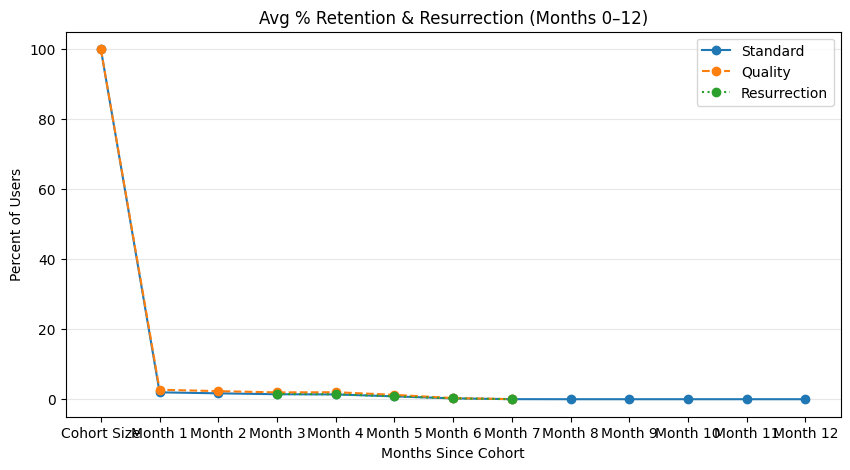

In [12]:
# Side by side comparison
comparison = pd.concat(
    {"Standard": retention_pct.iloc[:,:13],
     "Quality" : quality_retention_pct.iloc[:,:13]},
    axis=1, keys=["Standard","Quality"]
)
display(comparison.head(12))

plt.figure(figsize=(10,5))
plt.plot(retention_pct.mean().iloc[:13], marker="o", label="Standard")
plt.plot(quality_retention_pct.mean().iloc[:13], marker="o", linestyle="--", label="Quality")
plt.plot(resurrection_rate.mean().iloc[:13], marker="o", linestyle=":", label="Resurrection")
plt.title("Avg % Retention & Resurrection (Months 0–12)")
plt.xlabel("Months Since Cohort")
plt.ylabel("Percent of Users")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.show()

## This analysis showed strong initial acquisition but steep retention drop offs after the 1st Month. Resurrection rates are low, suggesting limited organic reactivation. Higher value customers retained better, highlighting an opportunity to target quality segments and invest in early engagement to improve long term retention and revenue.

# **Question 2: Customer Lifetime Value & Acquisition Efficiency**

# **Customer segmentation**

In [13]:
# First purchase date
first_purchase = (
    orders.groupby("user_id")["created_at"]
          .min()
          .reset_index()
          .rename(columns={"created_at": "first_purchase_date"})
)

# Merge back
orders_90 = orders.merge(first_purchase, on="user_id")

# Flag orders in first 90 days
orders_90["within_90_days"] = (
    orders_90["created_at"] <= (orders_90["first_purchase_date"] + pd.Timedelta(days=90))
)

# Aggregate
segmentation = (
    orders_90[orders_90["within_90_days"]]
      .groupby("user_id")
      .agg(
          orders_in_90=("invoice_id", "nunique"),
          spend_in_90=("price", "sum")
      )
      .reset_index()
)

# Segment label
def label_segment(row):
    if row["orders_in_90"] == 1:
        return "Single Purchaser, High Value" if row["spend_in_90"] >= 50 else "Single Purchaser, Low Value"
    else:
        return "Repeat Purchaser, High Value" if row["spend_in_90"] >= 50 else "Repeat Purchaser, Low Value"

segmentation["segment"] = segmentation.apply(label_segment, axis=1)

display(segmentation.head())

,user_id,orders_in_90,spend_in_90,segment
0,17.0,1,243.00,"Single Purchaser, High Value"
1,25.0,1,1.80,"Single Purchaser, Low Value"
2,63.0,1,585.00,"Single Purchaser, High Value"
3,65.0,1,44.50,"Single Purchaser, Low Value"
4,69.0,1,9.42,"Single Purchaser, Low Value"


# **CLV calculation**

In [15]:
# Aggregate all time
user_orders = (
    orders.groupby("user_id")
      .agg(
          first_order_date=("created_at", "min"),
          last_order_date=("created_at", "max"),
          total_orders=("invoice_id", "nunique"),
          total_spend=("price", "sum")
      )
      .reset_index()
)

# Lifespan in months
user_orders["lifespan_months"] = (
    (user_orders["last_order_date"] - user_orders["first_order_date"]).dt.days / 30.0
).clip(lower=1.0)  # Min lifespan = 1 month (avoids dividing by 0)

user_orders["aov"] = user_orders["total_spend"] / user_orders["total_orders"]

# Purchase frequency
user_orders["orders_per_month"] = user_orders["total_orders"] / user_orders["lifespan_months"]

user_orders = user_orders.merge(
    segmentation[["user_id", "segment"]],
    on="user_id",
    how="left"
)

display(user_orders.head())

,user_id,first_order_date,last_order_date,total_orders,total_spend,lifespan_months,aov,orders_per_month,segment
0,17.0,2013-05-24 22:00:27,2013-05-24 22:00:27,1,243.00,1.0,243.00,1.0,"Single Purchaser, High Value"
1,25.0,2013-05-18 21:44:54,2013-05-18 21:44:54,1,1.80,1.0,1.80,1.0,"Single Purchaser, Low Value"
2,63.0,2013-07-04 23:19:50,2013-07-04 23:19:50,1,585.00,1.0,585.00,1.0,"Single Purchaser, High Value"
3,65.0,2013-05-11 06:52:32,2013-05-11 06:52:32,1,44.50,1.0,44.50,1.0,"Single Purchaser, Low Value"
4,69.0,2013-08-08 09:56:12,2013-08-08 09:56:12,1,9.42,1.0,9.42,1.0,"Single Purchaser, Low Value"


In [16]:
# Averages per segment
segment_summary = (
    user_orders.groupby("segment")
      .agg(
          avg_aov=("aov", "mean"),
          avg_orders_per_month=("orders_per_month", "mean"),
          avg_lifespan_months=("lifespan_months", "mean")
      )
      .reset_index()
)

# Predicted CLV
segment_summary["predicted_clv"] = (
    segment_summary["avg_aov"] *
    segment_summary["avg_orders_per_month"] *
    segment_summary["avg_lifespan_months"]
).round(2)

display(segment_summary)

,segment,avg_aov,avg_orders_per_month,avg_lifespan_months,predicted_clv
0,"Repeat Purchaser, High Value",262.525388,1.468916,1.659437,639.93
1,"Repeat Purchaser, Low Value",13.863531,1.454012,1.624859,32.75
2,"Single Purchaser, High Value",353.134388,0.987251,1.082022,377.23
3,"Single Purchaser, Low Value",24.774693,0.986847,1.084340,26.51


# **Acquisition ROI**

In [17]:
# Max CAC = Predicted CLV / 3

segment_summary["max_cac"] = (segment_summary["predicted_clv"] / 3).round(2)

# **Validation**

In [26]:
# Users with ≥12 months lifespan
long_lived_users = user_orders[user_orders["lifespan_months"] >= 12.0]


validation_means = (
    long_lived_users.groupby("segment")
      .agg(
          avg_actual_clv=("total_spend", "mean"),
          mean_aov=("aov", "mean"),
          mean_orders_per_month=("orders_per_month", "mean"),
          mean_lifespan_months=("lifespan_months", "mean")
      )
      .reset_index()
)

validation_means["avg_predicted_clv"] = (
    validation_means["mean_aov"] *
    validation_means["mean_orders_per_month"] *
    validation_means["mean_lifespan_months"]
).round(2)

display(validation_means)

,segment,avg_actual_clv,mean_aov,mean_orders_per_month,mean_lifespan_months,avg_predicted_clv


## When filtering for customers with ≥12 months of purchase history, no users met this criterion in the dataset. Thus the validation step returned no data.

# **Final / Combined Output Table**

In [20]:
final_output = segment_summary[[
    "segment",
    "avg_aov",
    "avg_orders_per_month",
    "avg_lifespan_months",
    "predicted_clv",
    "max_cac"
]]

final_output.columns = [
    "Segment",
    "Avg Order Value ($)",
    "Orders per Month",
    "Est. Lifespan (Months)",
    "Predicted CLV ($)",
    "Max CAC ($)"
]

display(final_output)

,Segment,Avg Order Value ($),Orders per Month,Est. Lifespan (Months),Predicted CLV ($),Max CAC ($)
0,"Repeat Purchaser, High Value",262.525388,1.468916,1.659437,639.93,213.31
1,"Repeat Purchaser, Low Value",13.863531,1.454012,1.624859,32.75,10.92
2,"Single Purchaser, High Value",353.134388,0.987251,1.082022,377.23,125.74
3,"Single Purchaser, Low Value",24.774693,0.986847,1.084340,26.51,8.84


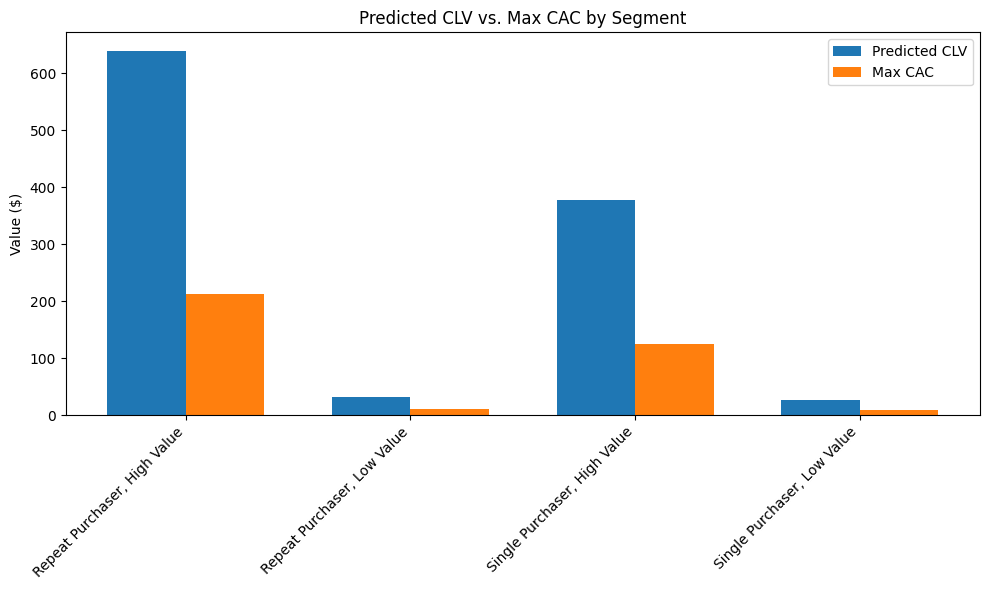

In [28]:
x = np.arange(len(final_output))
w = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - w/2, final_output["Predicted CLV ($)"], w, label="Predicted CLV")
ax.bar(x + w/2, final_output["Max CAC ($)"],     w, label="Max CAC")

ax.set_xticks(x)
ax.set_xticklabels(final_output["Segment"], rotation=45, ha="right")
ax.set(title="Predicted CLV vs. Max CAC by Segment", ylabel="Value ($)")
ax.legend()

plt.tight_layout()
plt.show()

## The CLV model revealed large differences between customer segments, with single low value purchasers contributing to minimal lifetime value. Predicted CLV enabled clear acquisition cost thresholds per segment. This equips marketing teams to to optimize spending and prioritize high-value segments, and set sustainable CAC targets aligned with long-term profitability.

# **Question 3: Growth Decomposition & Revenue Health**

**Prepare monthly revenue per customer by extracting order month and revenue per user per month**


In [29]:
# Converting order date to Year-Month
orders["order_month"] = orders["created_at"].dt.to_period("M").astype(str)

# Aggregate total revenue per customer per month
monthly_revenue = (
    orders.groupby(["user_id", "order_month"])
          .agg(month_revenue=("price", "sum"))
          .reset_index()
)

display(monthly_revenue.head())

,user_id,order_month,month_revenue
0,17.0,2013-05,243.00
1,25.0,2013-05,1.80
2,63.0,2013-07,585.00
3,65.0,2013-05,44.50
4,69.0,2013-08,9.42


## Identifying the first purchase month per user lets us see when each customer became a customer.

In [34]:
first_purchase_month = (
    monthly_revenue.groupby("user_id")["order_month"]
                   .min()
                   .reset_index()
                   .rename(columns={"order_month": "first_month"})
)

monthly_revenue = monthly_revenue.merge(first_purchase_month, on="user_id")

## Create pivot: revenue per customer per month

In [32]:
revenue_pivot = monthly_revenue.pivot_table(
    index="user_id",
    columns="order_month",
    values="month_revenue",
    fill_value=0
)

display(revenue_pivot.head())

order_month,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06
user_id,,,,,,,,,,,,,,,,,,,,,
17.0,0.0,0.0,243.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25.0,0.0,0.0,1.8,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63.0,0.0,0.0,0.0,0.0,585.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65.0,0.0,0.0,44.5,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69.0,0.0,0.0,0.0,0.0,0.0,9.42,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Calculate growth components month by month

In [36]:
all_months = sorted(monthly_revenue["order_month"].unique())

growth_components = []

for i, month in enumerate(all_months):
    if i == 0:
        # Skip first month
        continue

    prev_month = all_months[i - 1]

    # Prior and current revenue per customer
    temp = revenue_pivot[[prev_month, month]].copy()
    temp.columns = ["prev_revenue", "curr_revenue"]

    # New customers: first_month = current month
    new_revenue = monthly_revenue[
        (monthly_revenue["order_month"] == month) &
        (monthly_revenue["first_month"] == month)
    ]["month_revenue"].sum()

    # Existing customers (revenue for last month)
    existing = temp[temp["prev_revenue"] > 0]

    # Expansion
    expansion = (existing["curr_revenue"] - existing["prev_revenue"])
    expansion_sum = expansion[expansion > 0].sum()

    # Contraction
    contraction_sum = expansion[expansion < 0].sum()

    # Churn
    churn_sum = existing[existing["curr_revenue"] == 0]["prev_revenue"].sum()

    total_revenue = revenue_pivot[month].sum()

    growth_components.append({
        "Month": month,
        "Total Revenue": total_revenue,
        "New Customer Revenue": new_revenue,
        "Expansion": expansion_sum,
        "Contraction": contraction_sum,
        "Churn": churn_sum
    })

growth_df = pd.DataFrame(growth_components)

display(growth_df)

,Month,Total Revenue,New Customer Revenue,Expansion,Contraction,Churn
0,2013-04,568.970,568.970,0.000,-500.400,500.400
1,2013-05,3544.185,3544.185,0.000,-568.970,568.970
2,2013-06,6412.150,6412.150,0.000,-3544.185,3544.185
3,2013-07,12604.605,12604.605,0.000,-6412.150,6412.150
4,2013-08,20411.380,18721.380,286.600,-12551.205,12551.205
...,...,...,...,...,...,...
58,2018-02,124449.935,116532.930,1312.540,-126565.165,125224.875
59,2018-03,130262.460,124577.705,211.490,-123478.185,119899.185
60,2018-04,120699.675,114607.445,379.650,-129486.760,127426.290
61,2018-05,125460.790,116606.160,1831.345,-119542.240,118331.830


## From 2013–2018, over 80–90% of monthly revenue came from new customers, with high churn and contraction of existing buyers. This suggests growth was primarily driven by acquisition, and that retention strategies were likely underdeveloped.

# **Calculate Net Revenue Retention (NRR) = (Existing Customer Revenue after expansion/contraction/churn) / Prior Month Existing Revenue**

In [37]:
# List of prior month revenue sums
prior_existing_revenue = []
current_existing_revenue = []

for i, month in enumerate(all_months):
    if i == 0:
        prior_existing_revenue.append(None)
        current_existing_revenue.append(None)
        continue

    prev_month = all_months[i - 1]

    # Active customers in the prior month
    active_last_month = revenue_pivot[prev_month][revenue_pivot[prev_month] > 0]

    prior_sum = active_last_month.sum()

    # Revenue sum
    curr_sum = revenue_pivot.loc[active_last_month.index, month].sum()

    prior_existing_revenue.append(prior_sum)
    current_existing_revenue.append(curr_sum)

growth_df["Prior Existing Revenue"] = prior_existing_revenue[1:]
growth_df["Current Existing Revenue"] = current_existing_revenue[1:]

growth_df["NRR (%)"] = (
    (growth_df["Current Existing Revenue"] / growth_df["Prior Existing Revenue"]) * 100
).round(1)

display(growth_df)

,Month,Total Revenue,New Customer Revenue,Expansion,Contraction,Churn,Prior Existing Revenue,Current Existing Revenue,NRR (%)
0,2013-04,568.970,568.970,0.000,-500.400,500.400,500.400,0.00,0.0
1,2013-05,3544.185,3544.185,0.000,-568.970,568.970,568.970,0.00,0.0
2,2013-06,6412.150,6412.150,0.000,-3544.185,3544.185,3544.185,0.00,0.0
3,2013-07,12604.605,12604.605,0.000,-6412.150,6412.150,6412.150,0.00,0.0
4,2013-08,20411.380,18721.380,286.600,-12551.205,12551.205,12604.605,340.00,2.7
...,...,...,...,...,...,...,...,...,...
58,2018-02,124449.935,116532.930,1312.540,-126565.165,125224.875,127726.375,2473.75,1.9
59,2018-03,130262.460,124577.705,211.490,-123478.185,119899.185,124449.935,1183.24,1.0
60,2018-04,120699.675,114607.445,379.650,-129486.760,127426.290,130262.460,1155.35,0.9
61,2018-05,125460.790,116606.160,1831.345,-119542.240,118331.830,120699.675,2988.78,2.5


## NRR is consistently 0% or near 0% across most months, indicating that nearly all revenue each month came from newly acquired customers. Churn and contraction exceeded any expansion, which underscores a high reliance on acquisition rather than retention. Thus growth is unsustainable without substantial improvements in repeat purchasing or subscription adoption.

# **Growth Sustainability Analysis**

In [38]:
growth_df["% New Revenue"] = (
    (growth_df["New Customer Revenue"] / growth_df["Total Revenue"]) * 100
).round(1)

display(growth_df)

,Month,Total Revenue,New Customer Revenue,Expansion,Contraction,Churn,Prior Existing Revenue,Current Existing Revenue,NRR (%),% New Revenue
0,2013-04,568.970,568.970,0.000,-500.400,500.400,500.400,0.00,0.0,100.0
1,2013-05,3544.185,3544.185,0.000,-568.970,568.970,568.970,0.00,0.0,100.0
2,2013-06,6412.150,6412.150,0.000,-3544.185,3544.185,3544.185,0.00,0.0,100.0
3,2013-07,12604.605,12604.605,0.000,-6412.150,6412.150,6412.150,0.00,0.0,100.0
4,2013-08,20411.380,18721.380,286.600,-12551.205,12551.205,12604.605,340.00,2.7,91.7
...,...,...,...,...,...,...,...,...,...,...
58,2018-02,124449.935,116532.930,1312.540,-126565.165,125224.875,127726.375,2473.75,1.9,93.6
59,2018-03,130262.460,124577.705,211.490,-123478.185,119899.185,124449.935,1183.24,1.0,95.6
60,2018-04,120699.675,114607.445,379.650,-129486.760,127426.290,130262.460,1155.35,0.9,95.0
61,2018-05,125460.790,116606.160,1831.345,-119542.240,118331.830,120699.675,2988.78,2.5,92.9


## Revenue is overwhelmingly driven by new acquisitions, with NRR below 5% in nearly every month. Without substantial improvements in repeat buying, growth is not sustainable.

In [40]:
summary = growth_df[[
    "Month",
    "Total Revenue",
    "New Customer Revenue",
    "% New Revenue",
    "NRR (%)"
]]

display(summary)

,Month,Total Revenue,New Customer Revenue,% New Revenue,NRR (%)
0,2013-04,568.970,568.970,100.0,0.0
1,2013-05,3544.185,3544.185,100.0,0.0
2,2013-06,6412.150,6412.150,100.0,0.0
3,2013-07,12604.605,12604.605,100.0,0.0
4,2013-08,20411.380,18721.380,91.7,2.7
...,...,...,...,...,...
58,2018-02,124449.935,116532.930,93.6,1.9
59,2018-03,130262.460,124577.705,95.6,1.0
60,2018-04,120699.675,114607.445,95.0,0.9
61,2018-05,125460.790,116606.160,92.9,2.5


## Growth decomposition shows that across the entire observation window, over 90% of monthly revenue came from new customer acquisition, while NRR consistently remained below 5%. This indicates that growth was not supported by repeat purchasing or expansion revenue. Sustaining this trajectory will require significant improvements in customer retention and monetization.

****

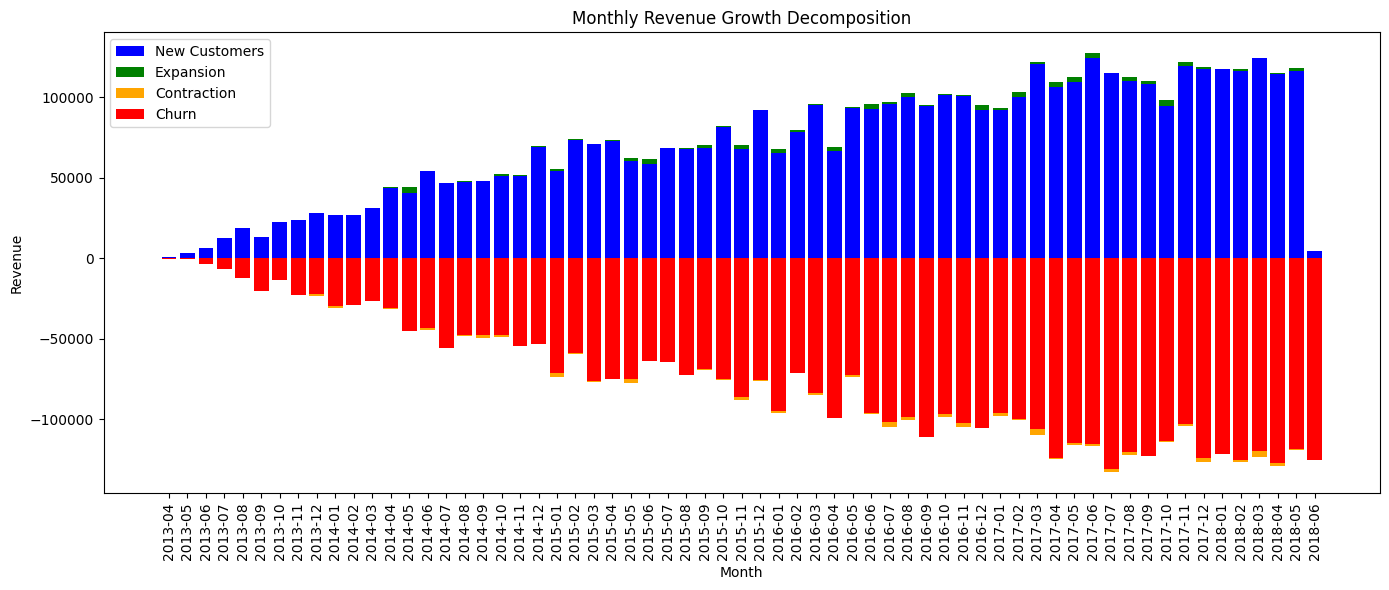

In [42]:
plt.figure(figsize=(14,6))

# New Customers
plt.bar(growth_df["Month"], growth_df["New Customer Revenue"], label="New Customers", color="blue")

# Expansion
plt.bar(growth_df["Month"], growth_df["Expansion"],
        bottom=growth_df["New Customer Revenue"], label="Expansion", color="green")

# Contraction
plt.bar(growth_df["Month"], growth_df["Contraction"], label="Contraction", color="orange")

# Churn
plt.bar(growth_df["Month"], -growth_df["Churn"], label="Churn", color="red")

plt.title("Monthly Revenue Growth Decomposition")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## You can see that almost all revenue was driven by new customer acquisition, while consistently offset most of the prior month’s gains. Expansion and contraction were minimal, highlighting a significant dependence on acquisition for growth.

# **Question 4: Customer Risk Scoring & Churn Prevention**

**Risk score calculation, Calculate Core Metrics per Customer**

**Recency**

In [64]:
# Recent purchase per customer
recency_days = (
    orders.groupby("user_id")["created_at"]
          .max()
          .reset_index()
          .rename(columns={"created_at": "last_purchase"})
)

# Days since last purchase (assuming dataset ends at max date)
max_date = orders["created_at"].max()
recency_days["days_since_last"] = (
    (max_date - recency_days["last_purchase"]).dt.days
)

**Frequency**

In [62]:
# Number of purchases
frequency = (
    orders.groupby("user_id")["invoice_id"]
          .nunique()
          .reset_index()
          .rename(columns={"invoice_id": "num_orders"})
)

**Monetary**

In [61]:
monetary = (
    orders.groupby("user_id")["price"]
          .sum()
          .reset_index()
          .rename(columns={"price": "total_spend"})
)

**Engagement**

In [60]:
# Unique product
category_diversity = (
    orders.groupby("user_id")["item_category"]
          .nunique()
          .reset_index()
          .rename(columns={"item_category": "num_categories"})
)

# Average order size
order_size = (
    orders.groupby("user_id")["price"]
          .mean()
          .reset_index()
          .rename(columns={"price": "avg_order_size"})
)

In [49]:
metrics = recency_days.merge(frequency, on="user_id") \
                      .merge(monetary, on="user_id") \
                      .merge(category_diversity, on="user_id") \
                      .merge(order_size, on="user_id")

## Risk Scoring System, Normalize each metric to a 0–1 scale, where:

## Higher recency (more days) = higher risk
## Lower frequency = higher risk
## Lower spend = higher risk
## Lower engagement = higher risk

<Axes: >

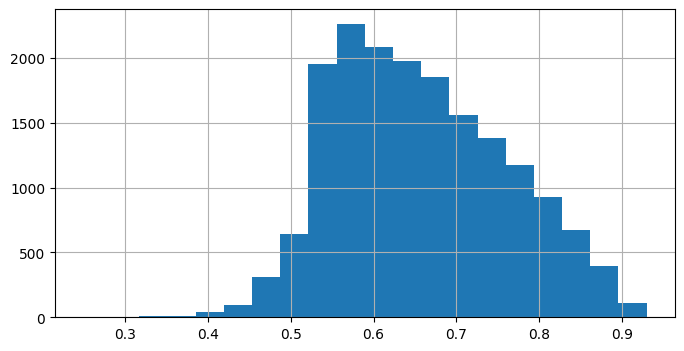

In [59]:
metrics["recency_score"] = metrics["days_since_last"] / metrics["days_since_last"].max()
metrics["frequency_score"] = 1 - (metrics["num_orders"] / metrics["num_orders"].max())
metrics["monetary_score"] = 1 - (metrics["total_spend"] / metrics["total_spend"].max())
metrics["engagement_score"] = 1 - (
    (metrics["num_categories"] / metrics["num_categories"].max() +
     metrics["avg_order_size"] / metrics["avg_order_size"].max()) / 2
)

metrics["risk_score"] = (
    0.4 * metrics["recency_score"] +
    0.2 * metrics["frequency_score"] +
    0.2 * metrics["monetary_score"] +
    0.2 * metrics["engagement_score"]
).round(3)

metrics["risk_score"].hist(bins=20, figsize=(8,4))

## This histogram shows the customer risk scoring distribution, where higher values indicate greater churn risk. The bulk of the customer base falls into moderate to high risk tiers, with relatively few highly engaged low risk customers. This supports the conclusion that the business currently relies heavily on one time or infrequent purchases, and retention is a significant opportunity area.

**Churn prediction**

In [58]:
metrics["inactive_30_plus"] = metrics["days_since_last"] >= 30

In [57]:
# Deciles of risk
metrics["risk_decile"] = pd.qcut(metrics["risk_score"], 10, labels=False)

# (e.g., decile 0: 80% return, decile 9: 5% return)

decile_prob_map = {
    0: 0.8,
    1: 0.7,
    2: 0.6,
    3: 0.5,
    4: 0.4,
    5: 0.3,
    6: 0.2,
    7: 0.15,
    8: 0.1,
    9: 0.05
}

metrics["prob_return"] = metrics["risk_decile"].map(decile_prob_map)

**Value at Risk & Prioritization**

In [56]:
metrics["clv_proxy"] = metrics["total_spend"]

clv_cutoff = metrics["clv_proxy"].quantile(0.8)
metrics["high_value"] = metrics["clv_proxy"] >= clv_cutoff

metrics["priority_score"] = metrics["risk_score"] * metrics["clv_proxy"]

priority_list = metrics.sort_values("priority_score", ascending=False)

top_50 = priority_list.head(50)
display(top_50[["user_id","risk_score","clv_proxy","prob_return"]])

,user_id,risk_score,clv_proxy,prob_return
1443,22576.0,0.646,3320.00,0.40
361,5499.0,0.719,2700.00,0.15
789,11940.0,0.688,2763.00,0.20
1169,17805.0,0.605,3099.95,0.50
1002,15295.0,0.688,2675.00,0.20
2996,46550.0,0.619,2850.00,0.40
1749,27331.0,0.671,2625.00,0.30
2629,41147.0,0.611,2800.00,0.50
3402,52567.0,0.571,2992.50,0.60
326,4870.0,0.757,2250.00,0.10


**Recommended Intervention Timing**

In [63]:
def recommend_timing(decile):
    if decile <= 2:
        return "60+ days"
    elif decile <=5:
        return "30-60 days"
    elif decile <=7:
        return "15-30 days"
    else:
        return "Immediate"

metrics["intervention_timing"] = metrics["risk_decile"].apply(recommend_timing)

display(top_50[["user_id","risk_score","clv_proxy","prob_return","intervention_timing"]])

,user_id,risk_score,clv_proxy,prob_return,intervention_timing
1443,22576.0,0.646,3320.00,0.40,30-60 days
361,5499.0,0.719,2700.00,0.15,15-30 days
789,11940.0,0.688,2763.00,0.20,15-30 days
1169,17805.0,0.605,3099.95,0.50,30-60 days
1002,15295.0,0.688,2675.00,0.20,15-30 days
2996,46550.0,0.619,2850.00,0.40,30-60 days
1749,27331.0,0.671,2625.00,0.30,30-60 days
2629,41147.0,0.611,2800.00,0.50,30-60 days
3402,52567.0,0.571,2992.50,0.60,60+ days
326,4870.0,0.757,2250.00,0.10,Immediate


## This table lists the top 50 customers with the highest combination of churn risk and potential value loss. The risk_score reflects recency, frequency, monetary, and engagement factors. The clv_proxy estimates the revenue at risk. The prob_return column indicates the likelihood of these customers returning without intervention. The intervention_timing suggests the optimal window for outreach based on historical recovery rates.

## Immediate = highest urgency
## 15–30 days = medium urgency
## 30–60 days = lower urgency but still recommended
## 60+ days = lowest urgency or longer tail follow-up

# **Overall Conclusion**

### This analysis provided a comprehensive view of customer behavior and revenue dynamics. Cohort retention patterns revealed limited long term engagement, with most revenue driven by new acquisitions. Customer lifetime value varied significantly across segments, informing clear acquisition cost benchmarks. Growth decomposition showed heavy dependence on new customer revenue and high churn offsetting gains. Finally, the risk scoring framework identified priority customers combining high churn risk and substantial revenue potential. These insights equip the business to focus retention efforts where they will have the greatest impact, optimize acquisition spend, and improve customer lifetime value through targeted interventions.